# 02b - Neural Network Classifier

Train a PyTorch neural network to predict Kerala districts from VAE embeddings.

**Goal:** Train and evaluate a feedforward neural network on the embeddings.

**Steps:**
1. Load processed embeddings with district labels
2. Create PyTorch datasets and dataloaders
3. Define neural network architecture
4. Train with validation
5. Evaluate and save model

## Setup

In [40]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

from src.training import get_device

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: district_prediction
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Load Data

In [41]:
# Load embeddings with district labels
data_path = Path('../data/processed/embeddings_with_districts.npz')

print(f'Loading data from: {data_path}')
data = np.load(data_path, allow_pickle=True)

X = data['embeddings'].astype(np.float32)
y_str = data['districts']

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)

print(f'\n✓ Loaded dataset')
print(f'  Samples: {len(X):,}')
print(f'  Features (embedding dim): {X.shape[1]}')
print(f'  Districts: {len(label_encoder.classes_)}')
print(f'\nDistrict mapping:')
for i, district in enumerate(label_encoder.classes_):
    print(f'  {i}: {district}')

Loading data from: ..\data\processed\embeddings_with_districts.npz

✓ Loaded dataset
  Samples: 64,884
  Features (embedding dim): 16
  Districts: 14

District mapping:
  0: Alappuzha
  1: Ernakulam
  2: Idukki
  3: Kannur
  4: Kasaragod
  5: Kollam
  6: Kottayam
  7: Kozhikode
  8: Malappuram
  9: Palakkad
  10: Pathanamthitta
  11: Thiruvananthapuram
  12: Thrissur
  13: Wayanad


## 2. Train/Val/Test Split

In [42]:
# Split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f'Dataset split:')
print(f'  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'  Val:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)')
print(f'  Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)')

Dataset split:
  Train: 45,444 samples (70.0%)
  Val:   9,707 samples (15.0%)
  Test:  9,733 samples (15.0%)


## 3. Create PyTorch Datasets and DataLoaders

In [43]:
# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)

X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Create dataloaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'\n✓ Created dataloaders')
print(f'  Batch size: {batch_size}')
print(f'  Train batches: {len(train_loader)}')
print(f'  Val batches: {len(val_loader)}')
print(f'  Test batches: {len(test_loader)}')


✓ Created dataloaders
  Batch size: 128
  Train batches: 356
  Val batches: 76
  Test batches: 77


## 4. Define Neural Network Architecture

In [44]:
class DistrictClassifier(nn.Module):
    """Feedforward neural network for district classification."""
    
    def __init__(self, input_dim, num_classes, hidden_dims=[64, 64, 64, 64, 32], dropout=0.3):
        super(DistrictClassifier, self).__init__()
        
        layers = []
        
        # Input layer
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create model
device = get_device()
input_dim = X.shape[1]
num_classes = len(label_encoder.classes_)

model = DistrictClassifier(
    input_dim=input_dim,
    num_classes=num_classes,
    hidden_dims=[64, 64, 64, 64, 32],
    dropout=0.3
).to(device)

print(f'\n✓ Created model')
print(f'  Input dim: {input_dim}')
print(f'  Output dim: {num_classes} classes')
print(f'  Hidden dims: [64, 64, 64, 64, 32]')
print(f'  Device: {device}')
print(f'\nModel architecture:')
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nParameters:')
print(f'  Total: {total_params:,}')
print(f'  Trainable: {trainable_params:,}')

✓ Using CPU

✓ Created model
  Input dim: 16
  Output dim: 14 classes
  Hidden dims: [64, 64, 64, 64, 32]
  Device: cpu

Model architecture:
DistrictClassifier(
  (network): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=32, out_features=14, bias=True)
  )
)

Parameters:
  Total: 16,110
  Trainable: 16,110


## 5. Training Configuration

In [45]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100

print(f'Training configuration:')
print(f'  Epochs: {num_epochs}')
print(f'  Optimizer: Adam (lr=0.0001, weight_decay=1e-5)')
print(f'  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)')
print(f'  Loss: CrossEntropyLoss')

Training configuration:
  Epochs: 100
  Optimizer: Adam (lr=0.0001, weight_decay=1e-5)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  Loss: CrossEntropyLoss


: 

## 6. Training Loop

In [46]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = Path('../models/district_nn_best.pth')
best_model_path.parent.mkdir(parents=True, exist_ok=True)

print('Starting training...\n')
print('='*70)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'label_encoder_classes': label_encoder.classes_
        }, best_model_path)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

print('='*70)
print(f'\n✓ Training complete!')
print(f'  Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)')
print(f'  Best model saved to: {best_model_path}')

Starting training...

Epoch [  1/100] | Train Loss: 1.9432, Acc: 0.3647 | Val Loss: 1.7971, Acc: 0.4175
Epoch [  5/100] | Train Loss: 1.8300, Acc: 0.4073 | Val Loss: 1.7416, Acc: 0.4313
Epoch [ 10/100] | Train Loss: 1.8293, Acc: 0.4051 | Val Loss: 1.7451, Acc: 0.4373
Epoch [ 15/100] | Train Loss: 1.7827, Acc: 0.4226 | Val Loss: 1.7086, Acc: 0.4439
Epoch [ 20/100] | Train Loss: 1.7758, Acc: 0.4211 | Val Loss: 1.7006, Acc: 0.4489
Epoch [ 25/100] | Train Loss: 1.7806, Acc: 0.4221 | Val Loss: 1.6933, Acc: 0.4489
Epoch [ 30/100] | Train Loss: 1.7639, Acc: 0.4259 | Val Loss: 1.6965, Acc: 0.4524
Epoch [ 35/100] | Train Loss: 1.7395, Acc: 0.4337 | Val Loss: 1.6654, Acc: 0.4549
Epoch [ 40/100] | Train Loss: 1.7281, Acc: 0.4383 | Val Loss: 1.6619, Acc: 0.4597
Epoch [ 45/100] | Train Loss: 1.7203, Acc: 0.4424 | Val Loss: 1.6574, Acc: 0.4654
Epoch [ 50/100] | Train Loss: 1.7157, Acc: 0.4439 | Val Loss: 1.6473, Acc: 0.4628
Epoch [ 55/100] | Train Loss: 1.7100, Acc: 0.4428 | Val Loss: 1.6378, Acc: 0

## 7. Plot Training Curves

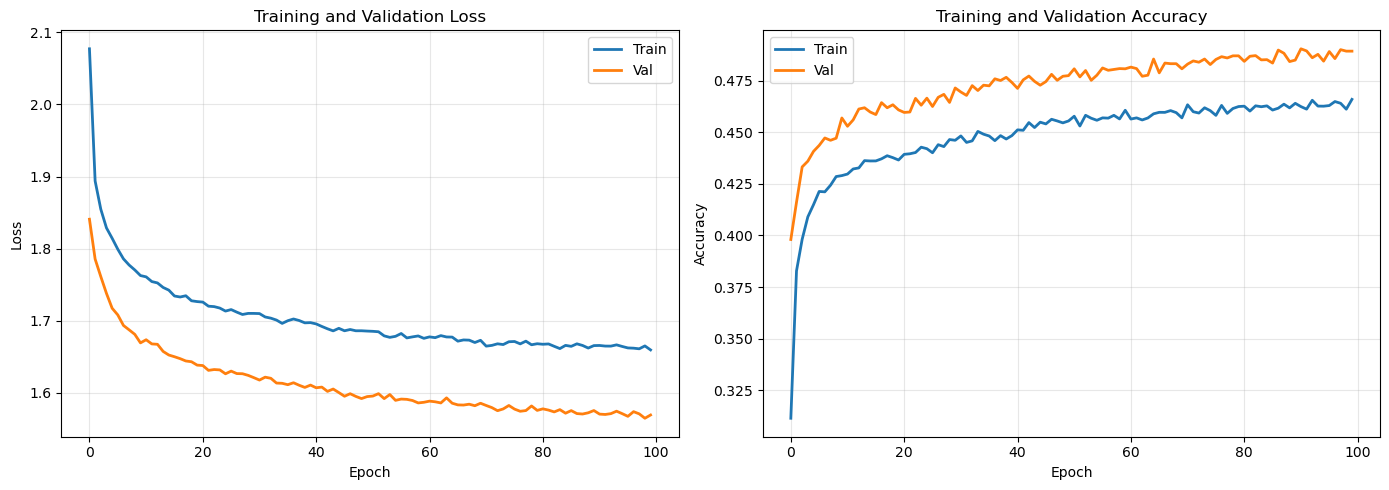

✓ Saved training curves


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train', linewidth=2)
ax1.plot(history['val_loss'], label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train', linewidth=2)
ax2.plot(history['val_acc'], label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/nn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'✓ Saved training curves')

## 8. Evaluate on Test Set

In [ ]:
# Load best model
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test evaluation
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

test_acc = test_correct / test_total

print('='*60)
print('TEST SET EVALUATION')
print('='*60)
print(f'\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)')
print('='*60)

TEST SET EVALUATION

Test Accuracy: 0.4853 (48.53%)
Best Val Accuracy: 0.4904 (49.04%)


In [ ]:
# Classification report
print('\nClassification Report:')
print('='*60)
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=label_encoder.classes_,
    digits=3
))


Classification Report:
                    precision    recall  f1-score   support

         Alappuzha      0.529     0.799     0.636      1758
         Ernakulam      0.412     0.424     0.418      1719
            Idukki      0.525     0.703     0.601       408
            Kannur      0.439     0.271     0.335       730
         Kasaragod      0.000     0.000     0.000        98
            Kollam      0.000     0.000     0.000       153
          Kottayam      0.580     0.097     0.166       299
         Kozhikode      0.000     0.000     0.000       247
        Malappuram      0.000     0.000     0.000       243
          Palakkad      0.603     0.440     0.509      1045
    Pathanamthitta      0.000     0.000     0.000       334
Thiruvananthapuram      0.430     0.130     0.200       307
          Thrissur      0.463     0.707     0.560      2228
           Wayanad      0.000     0.000     0.000       164

          accuracy                          0.485      9733
         macro

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## 9. Save Results

In [ ]:
# Save metrics
metrics = {
    'model_type': 'Neural Network',
    'architecture': 'Feedforward (128-64)',
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc),
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    'n_classes': num_classes,
    'n_epochs': num_epochs,
    'batch_size': batch_size,
    'total_params': total_params
}

metrics_path = Path('../results/tables/nn_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f'✓ Saved metrics to: {metrics_path}')

✓ Saved metrics to: ..\results\tables\nn_metrics.json


In [ ]:
# Save per-class metrics
report_dict = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)

summary_df = pd.DataFrame({
    'District': label_encoder.classes_,
    'Precision': [report_dict[d]['precision'] for d in label_encoder.classes_],
    'Recall': [report_dict[d]['recall'] for d in label_encoder.classes_],
    'F1-Score': [report_dict[d]['f1-score'] for d in label_encoder.classes_],
    'Support': [report_dict[d]['support'] for d in label_encoder.classes_]
})

summary_path = Path('../results/tables/nn_district_metrics.csv')
summary_df.to_csv(summary_path, index=False)

print(f'✓ Saved district metrics to: {summary_path}')
print('\nPer-district metrics:')
print(summary_df.to_string(index=False))

✓ Saved district metrics to: ..\results\tables\nn_district_metrics.csv

Per-district metrics:
          District  Precision   Recall  F1-Score  Support
         Alappuzha   0.528792 0.799204  0.636467   1758.0
         Ernakulam   0.411632 0.424084  0.417765   1719.0
            Idukki   0.524680 0.703431  0.601047    408.0
            Kannur   0.439024 0.271233  0.335309    730.0
         Kasaragod   0.000000 0.000000  0.000000     98.0
            Kollam   0.000000 0.000000  0.000000    153.0
          Kottayam   0.580000 0.096990  0.166189    299.0
         Kozhikode   0.000000 0.000000  0.000000    247.0
        Malappuram   0.000000 0.000000  0.000000    243.0
          Palakkad   0.602883 0.440191  0.508850   1045.0
    Pathanamthitta   0.000000 0.000000  0.000000    334.0
Thiruvananthapuram   0.430108 0.130293  0.200000    307.0
          Thrissur   0.463099 0.706912  0.559602   2228.0
           Wayanad   0.000000 0.000000  0.000000    164.0


c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## Summary

In [ ]:
print('='*60)
print('NEURAL NETWORK TRAINING COMPLETE')
print('='*60)
print(f'\n🧠 Model:')
print(f'   Architecture: Feedforward NN (128-64)')
print(f'   Parameters: {total_params:,}')
print(f'   Input: {input_dim}D embeddings')
print(f'   Output: {num_classes} districts')
print(f'\n📊 Performance:')
print(f'   Best Val Accuracy: {best_val_acc*100:.2f}%')
print(f'   Test Accuracy: {test_acc*100:.2f}%')
print(f'\n💾 Outputs:')
print(f'   Model: models/district_nn_best.pth')
print(f'   Metrics: results/tables/nn_metrics.json')
print(f'   District metrics: results/tables/nn_district_metrics.csv')
print(f'   Training curves: results/figures/nn_training_curves.png')
print('='*60)

NEURAL NETWORK TRAINING COMPLETE

🧠 Model:
   Architecture: Feedforward NN (128-64)
   Parameters: 16,110
   Input: 16D embeddings
   Output: 14 districts

📊 Performance:
   Best Val Accuracy: 49.04%
   Test Accuracy: 48.53%

💾 Outputs:
   Model: models/district_nn_best.pth
   Metrics: results/tables/nn_metrics.json
   District metrics: results/tables/nn_district_metrics.csv
   Training curves: results/figures/nn_training_curves.png
